In [1]:
add_to_lat = [0.001159, 0.0011448, 0.00115999987, 0.001140, 0.001129999, -0.001112, -0.00113983, -0.001118223, -0.00112982374]
add_to_lon = [-0.00125, -0.001259, -0.0011154302, -0.00113, -0.00129009, -0.001011, -0.00128245, -0.000982847, -0.00122559009]

In [2]:
prev_lat = -122.47309307787
prev_lon = 37.720040922129996
for i, j in zip(add_to_lat, add_to_lon):
    prev_lat = prev_lat + i
    prev_lon = prev_lon + i
    print(f",{prev_lat},{prev_lon}")

,-122.47193407787,37.72119992213
,-122.47078927787,37.722344722129996
,-122.469629278,37.723504721999994
,-122.46848927799999,37.724644721999994
,-122.467359279,37.72577472099999
,-122.468471279,37.724662720999994
,-122.469611109,37.723522890999995
,-122.470729332,37.722404667999996
,-122.47185915574,37.721274844259995


# Test DataPartition Class

In [5]:
import pandas as pd
df = pd.read_csv("/Users/bean/Documents/Doctorate/1Research/MapMetadata/mapmetadata/testing/test_osmnx.csv")
df.head()

,traj_id,timestamp,longitude,latitude
0,0_10-0,2021-01-01 07:31:20,-122.474327,37.718807
1,0_10-0,2021-01-01 07:31:40,-122.473167,37.717556
2,0_10-0,2021-01-01 07:32:00,-122.473168,37.719966
3,0_10-0,2021-01-01 07:32:20,-122.472023,37.721111
4,0_10-0,2021-01-01 07:32:40,-122.470863,37.722271


CODE FROM AUG 3

In [ ]:
import pandas as pd
import numpy as np

import datetime
from sklearn.cluster import KMeans
import osmnx as ox

class DataPartition:
    def __init__(self, df):

        # CONFIGS
        self.max_time_diff = pd.Timedelta(minutes=2)
        self.k = 4
        self.network_type = 'drive'
        self.buffer = 0.0005    # 50m buffer
        self.round_to = 6

        # DATASET
        self.traj_ids = df['traj_id'].to_list()
        self.timestamps = self.get_timestamp_list(col=df['timestamp'])
        self.latitudes = df['latitude'].to_list()
        self.longitudes = df['longitude'].to_list()

        self.num_points = len(df)

        # INDEXES
        self.time_group_idx, self.time_idx_exp, self.speeds = self.get_time_group_idx()
        self.space_group_mbrs, self.space_group_idx = self.get_space_groups()

        # DATA SUBSETS
        self.lats_in_time_groups = np.split(self.latitudes, self.time_group_idx)
        self.lons_in_time_groups = np.split(self.longitudes, self.time_group_idx)

    def print_group_indices(self):

        print(f"time group index: {self.time_group_idx}\n")
        print(f"time index expanded: {self.time_idx_exp}\n")
        print(f"space group MBRs: {self.space_group_mbrs}\n")
        print(f"space group index: {self.space_group_idx}\n")

        return

    def get_timestamp_list(self, col):
        """Convert timestamps to datetime objects"""
        dt = pd.to_datetime(col, errors = 'coerce')
        return dt.to_list()

    def get_time_group_idx(self):
        """
        Return:
            List of index intervals defining each time group
                All points in a time group are within the self.max_time_diff time difference
                All points in a time group are from the same trajectory
            Estimated speed at each point
                The last two points are given the same speed
        """
        time_group_intervals = []
        time_intervals_expanded = []
        time_diff = []
        dist_diff = []
        s = 0
        group_time_diff = pd.Timedelta(minutes=0)
        prev_id = self.traj_ids[0]
        prev_lat = self.latitudes[0]
        prev_lon = self.longitudes[0]
        prev_timestamp = self.timestamps[0]

        for i in range(1, (self.num_points-1)):

            cur_id = self.traj_ids[i]
            cur_lat = self.latitudes[i]
            cur_lon = self.longitudes[i]
            cur_timestamp = self.timestamps[i]

            if cur_id == prev_id:
                time_diff.append((cur_timestamp - prev_timestamp).total_seconds())
                dist_diff.append(round(np.linalg.norm(np.array([cur_lon, cur_lat], dtype=np.float32) 
                                                      - np.array([prev_lon, prev_lat], dtype=np.float32)), 
                                       self.round_to))
                # print(f"TIME D \t{(cur_timestamp - prev_timestamp).total_seconds()}")
                # print(f"DIST D \t{}")
                group_time_diff = cur_timestamp - self.timestamps[s]
                if (group_time_diff > self.max_time_diff):
                    time_group_intervals.append((s,i))
                    time_intervals_expanded.append(np.arange(s,i))
                    s = i
            else:
                # last two points of prev trajectory get same speed
                time_diff.append(time_diff[-1])
                dist_diff.append(dist_diff[-1])
                prev_id = cur_id
            
            prev_lat = cur_lat
            prev_lon = cur_lon
            prev_timestamp = cur_timestamp

        # last index - check if ids of last two points are the same, add correct ids to lists
        last_i = self.num_points - 1    # == i + 1
        cur_id = self.traj_ids[last_i]

        if cur_id != prev_id:   # corner case - last point not in same trajectory as penultimate point
            # add last group from loop
            time_group_intervals.append((s, i))
            time_intervals_expanded.append(np.arange(s, last_i))    # need last_i == i + 1 because we want [s, i]
            time_diff.append(time_diff[-1])
            dist_diff.append(dist_diff[-1])

            # add last point
            time_group_intervals.append(last_i, last_i)
            time_intervals_expanded.append(np.arange(last_i, self.num_points))
            time_diff.append(None)
            dist_diff.append(None)

        else:   # standard case - last point in same trajectory as penultimate point
            time_group_intervals.append((s, last_i))
            time_intervals_expanded.append(np.arange(s, self.num_points))

            cur_lat = self.latitudes[last_i]
            cur_lon = self.longitudes[last_i]
            time_diff.append((self.timestamps[last_i] - self.timestamps[i]).total_seconds())
            dist_diff.append(round(np.linalg.norm(np.array([cur_lon, cur_lat], dtype=np.float32) 
                                                  - np.array([prev_lon, prev_lat], dtype=np.float32)), 
                                   self.round_to))

        indices = [end for _, end in time_group_intervals[:-1]]  #TODO: make this the time_group_idx if we only need these vals   

        dt = [d/t for d, t in zip(dist_diff,time_diff)]
        dt.append(dt[-1])   # last two points have the same value

        return indices, time_intervals_expanded, dt
    
    def get_extrema(self):
        """
        CALLED BY GET_SPACE_GROUPS

        Get the min/max lat/long of the first and last points in a time group
        Return [min lat, max lat] , [min_long, max_long]
        """
        # indices = [end for _, end in self.time_group_idx[:-1]]  #TODO: make this the time_group_idx if we only need these vals   

        # [time group 1 [first point lat/lon, last point lat/lon], time group 2 [ first point, last point], ...]
        first_last_lats = np.matrix([[l[0], l[-1]] for l in np.split(self.latitudes, self.time_group_idx)])
        first_last_lons = np.matrix([[l[0], l[-1]] for l in np.split(self.longitudes, self.time_group_idx)])
        
        sorted_lats = np.asarray(np.sort(first_last_lats, axis=1))
        sorted_lons = np.asarray(np.sort(first_last_lons, axis=1))

        return sorted_lats, sorted_lons

    def get_bbox(self, lat, lon):
        """
        CALLED BY GET_SPACE_GROUPS

        Given a space group label, get all the lat/lon values [time group values] that are in that space group
            (lat/lon are list of [min val, max val] of each time group, and you mask by space group label i)
        Return (min_long, min_lat, max_long, max_lat) == (left, bottom, right, top)
        """
        w_min_lon = min(lon) - self.buffer
        s_min_lat = min(lat) - self.buffer
        e_max_lon = max(lon) + self.buffer
        n_max_lat = max(lat) + self.buffer
        return (w_min_lon, s_min_lat, e_max_lon, n_max_lat)

    def get_space_groups(self):
        """
        NOTES:  Number of space groups is the number of road networks
                We want to get the smallest number of road networks that are small enough
                to make map matching fast, so we cluster all the MBRs into k groups

        Return:
            space_groups: mbr of each space group (there are k groups)
                mbr = [min_long, min_lat, max_long, max_lat] == [left, bottom, right, top]
            labels: list of corresponding space group index for each time group
                index is the index of the space group each time group belongs in
        """
        sorted_lats, sorted_lons = self.get_extrema()
        mbrs = np.hstack([sorted_lats, sorted_lons])

        centroids = [( (x1+x2)/2, (y1+y2)/2 ) for y1, y2, x1, x2 in mbrs]
        kmeans = KMeans(n_clusters = self.k).fit(centroids)
        labels = kmeans.labels_

        space_groups = []
        for i in range(self.k):
            space_groups.append(self.get_bbox(lat=sorted_lats[i].tolist(), lon=sorted_lons[i].tolist()))

        return space_groups, labels
    
    def get_road_network(self, mbr):
        """
        CALLED BY MAP_MATCH

        Return OSM road network within the given space group mbr
        """
        g = ox.graph_from_bbox(bbox=mbr, network_type=self.network_type, 
                               retain_all=True, truncate_by_edge=True, simplify=False)
        # return ox.projection.project_graph(g)
        return g

    def get_all_space_group_points(self, i):
        """
        CALLED BY MAP_MATCH

        Given a space group label
        Return all the point coordinates that correspond to that space group as a list
            need to return lat and long separately because osm.nearest_edges takes them separately
            if it is no longer needed, can do them all at once:
                points_in_space_group = [time_group for time_group, space_idx in zip(self.points_in_time_groups, self.space_group_idx) if space_idx == i]
                return np.vstack(points_in_space_group).tolist()
        """
        lats_in_space_group = np.hstack([time_group for time_group, space_idx in zip(self.lats_in_time_groups, self.space_group_idx) if space_idx == i]).tolist()
        lons_in_space_group = np.hstack([time_group for time_group, space_idx in zip(self.lons_in_time_groups, self.space_group_idx) if space_idx == i]).tolist()
        indices = np.hstack([time_idx for time_idx, space_idx in zip(self.time_idx_exp, self.space_group_idx) if space_idx == i]).tolist()
        return lats_in_space_group, lons_in_space_group, indices

    def map_match(self):
        """
        CALLED BY GET_POINTS_INFO

        For each of the k space groups:
            get all points in that group, 
            map match all points using that road network
        Return the matching edges and distance from edge for each point
            in sorted order (sorted like original df: by traj_id and timestamp)
        """
        #TODO maybe rewrite with zip
        edges = []
        distances = []
        u_distances = []
        v_distances = []
        indices = []    # original point indices in order of space group
        for i in range(self.k):

            Y, X, all_t_idx_for_s = self.get_all_space_group_points(i)
            G = self.get_road_network(self.space_group_mbrs[i])
            e, d = ox.distance.nearest_edges(G, X, Y, return_dist=True)

            u_dist = [round(np.linalg.norm(np.array([G.nodes[row[0]]['x'], G.nodes[row[0]]['y']]) 
                                           - np.array([x, y])), 
                            self.round_to) for row, x, y in zip(e, X, Y)]
            
            v_dist = [round(np.linalg.norm(np.array([G.nodes[row[1]]['x'], G.nodes[row[1]]['y']]) 
                                           - np.array([x, y])), 
                            self.round_to) for row, x, y in zip(e, X, Y)]

            edges.append(e)
            distances.append(d)
            u_distances.append(u_dist)
            v_distances.append(v_dist)
            indices.append(all_t_idx_for_s)

        edges_list = np.hstack(edges).tolist()
        distance_list = np.hstack(distances).tolist()
        u_dist_list = np.concatenate(u_distances).tolist()
        v_dist_list = np.concatenate(v_distances).tolist()
        indices_list = np.hstack(indices).tolist()


        paired_e = list(zip(indices_list, edges_list))
        sorted_edges = [value for _, value in paired_e]

        paired_d = list(zip(indices_list, distance_list))
        sorted_distances = [value for _, value in paired_d]

        paired_u_dists = list(zip(indices_list, u_dist_list))
        sorted_u_dists = [value for _, value in paired_u_dists]

        paired_v_dists = list(zip(indices_list, v_dist_list))
        sorted_v_dists = [value for _, value in paired_v_dists]

        return sorted_edges, sorted_distances, sorted_u_dists, sorted_v_dists
    
    def get_point_info(self):
        """
        Return an np array with all the points in df 
            ordered by their trajectory ids and timestamp.

            Currently array only has trajector id, speed, edge, 
            and distance from edge of each point
        """
        edges, distances, u_dist, v_dist = self.map_match()
        s, d, k = zip(*edges)
        # base_df = np.stack([self.traj_ids, self.latitudes, self.longitudes, self.speeds, s, d, k, u_dist, v_dist, distances]).transpose()
        base_df = np.stack([self.traj_ids, self.timestamps, self.speeds, s, d, k, u_dist, v_dist, distances]).transpose()
        return base_df

CODE FROM AUG 4

In [ ]:
import pandas as pd
import numpy as np

import datetime
from sklearn.cluster import KMeans
import osmnx as ox

class DataPartition:
    def __init__(self, df):

        # CONFIGS
        self.max_time_diff = pd.Timedelta(minutes=2)
        self.k = 4
        self.network_type = 'drive'
        self.buffer = 0.0005    # 50m buffer
        self.round_to = 6

        # DATASET
        self.traj_ids = df['traj_id'].to_list()
        self.timestamps = self.get_timestamp_list(col=df['timestamp'])
        self.latitudes = df['latitude'].to_list()
        self.longitudes = df['longitude'].to_list()

        self.num_points = len(df)

        # INDEXES
        self.time_group_idx, self.time_idx_exp, self.speeds = self.get_time_group_idx()
        self.space_group_mbrs, self.space_group_idx = self.get_space_groups()

        # DATA SUBSETS
        self.lats_in_time_groups = np.split(self.latitudes, self.time_group_idx)
        self.lons_in_time_groups = np.split(self.longitudes, self.time_group_idx)

    def print_group_indices(self):

        print(f"time group index: {self.time_group_idx}\n")
        print(f"time index expanded: {self.time_idx_exp}\n")
        print(f"space group MBRs: {self.space_group_mbrs}\n")
        print(f"space group index: {self.space_group_idx}\n")

        return

    def get_timestamp_list(self, col):
        """Convert timestamps to datetime objects"""
        dt = pd.to_datetime(col, errors = 'coerce')
        return dt.to_list()

    def dist_btwn_points(self, lat1, lon1, lat2, lon2):
        """Returns distance in km"""
        d = ox.distance.great_circle(lat1=lat1, lon1=lon1, lat2=lat2, lon2=lon2, earth_radius=6371.009)
        return round(d, self.round_to)

    def get_time_group_idx(self):
        """
        Return:
            List of index intervals defining each time group
                All points in a time group are within the self.max_time_diff time difference
                All points in a time group are from the same trajectory
            Estimated speed at each point
                The last two points are given the same speed
        """
        time_group_intervals = []
        time_intervals_expanded = []
        time_diff = []
        dist_diff = []
        s = 0
        group_time_diff = pd.Timedelta(minutes=0)
        prev_id = self.traj_ids[0]
        prev_lat = self.latitudes[0]
        prev_lon = self.longitudes[0]
        prev_timestamp = self.timestamps[0]

        def time_btwn_points(t1, t2):
            """Returns time in hours"""
            d = (t2 - t1).total_seconds()
            return round((d/3600), self.round_to)

        for i in range(1, (self.num_points-1)):

            cur_id = self.traj_ids[i]
            cur_lat = self.latitudes[i]
            cur_lon = self.longitudes[i]
            cur_timestamp = self.timestamps[i]

            if cur_id == prev_id:
                time_diff.append(time_btwn_points(prev_timestamp, cur_timestamp))
                dist_diff.append(self.dist_btwn_points(lat1=prev_lat, lon1=prev_lon, lat2=cur_lat, lon2=cur_lon))
                group_time_diff = cur_timestamp - self.timestamps[s]
                if (group_time_diff > self.max_time_diff):
                    time_group_intervals.append((s,i))
                    time_intervals_expanded.append(np.arange(s,i))
                    s = i
            else:
                # last two points of prev trajectory get same speed
                time_diff.append(time_diff[-1])
                dist_diff.append(dist_diff[-1])
                prev_id = cur_id
            
            prev_lat = cur_lat
            prev_lon = cur_lon
            prev_timestamp = cur_timestamp

        # last index - check if ids of last two points are the same, add correct ids to lists
        last_i = self.num_points - 1    # == i + 1
        cur_id = self.traj_ids[last_i]

        if cur_id != prev_id:   # corner case - last point not in same trajectory as penultimate point
            # add last group from loop
            time_group_intervals.append((s, i))
            time_intervals_expanded.append(np.arange(s, last_i))    # need last_i == i + 1 because we want [s, i]
            time_diff.append(time_diff[-1])
            dist_diff.append(dist_diff[-1])

            # add last point
            time_group_intervals.append(last_i, last_i)
            time_intervals_expanded.append(np.arange(last_i, self.num_points))
            time_diff.append(None)
            dist_diff.append(None)

        else:   # standard case - last point in same trajectory as penultimate point
            time_group_intervals.append((s, last_i))
            time_intervals_expanded.append(np.arange(s, self.num_points))

            cur_lat = self.latitudes[last_i]
            cur_lon = self.longitudes[last_i]
            time_diff.append(time_btwn_points(self.timestamps[i], self.timestamps[last_i]))
            dist_diff.append(self.dist_btwn_points(lat1=prev_lat, lon1=prev_lon, lat2=cur_lat, lon2=cur_lon))

        indices = [end for _, end in time_group_intervals[:-1]]  #TODO: make this the time_group_idx if we only need these vals   

        dt = [d/t for d, t in zip(dist_diff,time_diff)]
        dt.append(dt[-1])   # last two points have the same value

        return indices, time_intervals_expanded, dt
    
    def get_extrema(self):
        """
        CALLED BY GET_SPACE_GROUPS

        Get the min/max lat/long of the first and last points in a time group
        Return [min lat, max lat] , [min_long, max_long]
        """
        # indices = [end for _, end in self.time_group_idx[:-1]]  #TODO: make this the time_group_idx if we only need these vals   

        # [time group 1 [first point lat/lon, last point lat/lon], time group 2 [ first point, last point], ...]
        first_last_lats = np.matrix([[l[0], l[-1]] for l in np.split(self.latitudes, self.time_group_idx)])
        first_last_lons = np.matrix([[l[0], l[-1]] for l in np.split(self.longitudes, self.time_group_idx)])
        
        sorted_lats = np.asarray(np.sort(first_last_lats, axis=1))
        sorted_lons = np.asarray(np.sort(first_last_lons, axis=1))

        return sorted_lats, sorted_lons

    def get_bbox(self, lat, lon):
        """
        CALLED BY GET_SPACE_GROUPS

        Given a space group label, get all the lat/lon values [time group values] that are in that space group
            (lat/lon are list of [min val, max val] of each time group, and you mask by space group label i)
        Return (min_long, min_lat, max_long, max_lat) == (left, bottom, right, top)
        """
        w_min_lon = min(lon) - self.buffer
        s_min_lat = min(lat) - self.buffer
        e_max_lon = max(lon) + self.buffer
        n_max_lat = max(lat) + self.buffer
        return (w_min_lon, s_min_lat, e_max_lon, n_max_lat)

    def get_space_groups(self):
        """
        NOTES:  Number of space groups is the number of road networks
                We want to get the smallest number of road networks that are small enough
                to make map matching fast, so we cluster all the MBRs into k groups

        Return:
            space_groups: mbr of each space group (there are k groups)
                mbr = [min_long, min_lat, max_long, max_lat] == [left, bottom, right, top]
            labels: list of corresponding space group index for each time group
                index is the index of the space group each time group belongs in
        """
        sorted_lats, sorted_lons = self.get_extrema()
        mbrs = np.hstack([sorted_lats, sorted_lons])

        centroids = [( (x1+x2)/2, (y1+y2)/2 ) for y1, y2, x1, x2 in mbrs]
        kmeans = KMeans(n_clusters = self.k).fit(centroids)
        labels = kmeans.labels_

        space_groups = []
        for i in range(self.k):
            space_groups.append(self.get_bbox(lat=sorted_lats[i].tolist(), lon=sorted_lons[i].tolist()))

        return space_groups, labels
    
    def get_road_network(self, mbr):
        """
        CALLED BY MAP_MATCH

        Return OSM road network within the given space group mbr
        """
        g = ox.graph_from_bbox(bbox=mbr, network_type=self.network_type, 
                               retain_all=True, truncate_by_edge=True, simplify=False)
        # return ox.projection.project_graph(g)
        return g

    def get_all_space_group_points(self, i):
        """
        CALLED BY MAP_MATCH

        Given a space group label
        Return all the point coordinates that correspond to that space group as a list
            need to return lat and long separately because osm.nearest_edges takes them separately
            if it is no longer needed, can do them all at once:
                points_in_space_group = [time_group for time_group, space_idx in zip(self.points_in_time_groups, self.space_group_idx) if space_idx == i]
                return np.vstack(points_in_space_group).tolist()
        """
        lats_in_space_group = np.hstack([time_group for time_group, space_idx in zip(self.lats_in_time_groups, self.space_group_idx) if space_idx == i]).tolist()
        lons_in_space_group = np.hstack([time_group for time_group, space_idx in zip(self.lons_in_time_groups, self.space_group_idx) if space_idx == i]).tolist()
        indices = np.hstack([time_idx for time_idx, space_idx in zip(self.time_idx_exp, self.space_group_idx) if space_idx == i]).tolist()
        return lats_in_space_group, lons_in_space_group, indices

    def map_match(self):
        """
        CALLED BY GET_POINTS_INFO

        For each of the k space groups:
            get all points in that group, 
            map match all points using that road network
        Return the matching edges and distance from edge for each point
            in sorted order (sorted like original df: by traj_id and timestamp)
        """
        #TODO maybe rewrite with zip
        edges = []
        distances = []
        u_distances = []
        v_distances = []
        indices = []    # original point indices in order of space group
        for i in range(self.k):

            Y, X, all_t_idx_for_s = self.get_all_space_group_points(i)
            G = self.get_road_network(self.space_group_mbrs[i])
            e, d = ox.distance.nearest_edges(G, X, Y, return_dist=True)

            u_dist = [(self.dist_btwn_points(lat1=y, lon1=x, lat2=G.nodes[row[0]]['y'], lon2=G.nodes[row[0]]['x'])) for row, x, y in zip(e, X, Y)]
            v_dist = [(self.dist_btwn_points(lat1=y, lon1=x, lat2=G.nodes[row[1]]['y'], lon2=G.nodes[row[1]]['x'])) for row, x, y in zip(e, X, Y)]

            edges.append(e)
            distances.append(d)
            u_distances.append(u_dist)
            v_distances.append(v_dist)
            indices.append(all_t_idx_for_s)

        edges_list = np.hstack(edges).tolist()
        distance_list = np.hstack(distances).tolist()
        u_dist_list = np.concatenate(u_distances).tolist()
        v_dist_list = np.concatenate(v_distances).tolist()
        indices_list = np.hstack(indices).tolist()

        paired_e = list(zip(indices_list, edges_list))
        sorted_edges = [value for _, value in paired_e]

        paired_d = list(zip(indices_list, distance_list))
        sorted_distances = [value for _, value in paired_d]

        paired_u_dists = list(zip(indices_list, u_dist_list))
        sorted_u_dists = [value for _, value in paired_u_dists]

        paired_v_dists = list(zip(indices_list, v_dist_list))
        sorted_v_dists = [value for _, value in paired_v_dists]

        return sorted_edges, sorted_distances, sorted_u_dists, sorted_v_dists
    
    def get_point_info(self):
        """
        Return an np array with all the points in df 
            ordered by their trajectory ids and timestamp.

            Currently array only has trajector id, speed, edge, 
            and distance from edge of each point
        """
        edges, distances, u_dist, v_dist = self.map_match()
        s, d, k = zip(*edges)
        base_df = np.stack([self.traj_ids, self.timestamps, self.speeds, s, d, k, u_dist, v_dist, distances]).transpose()
        return base_df

AUG 3 OUTPUT

In [90]:
partition = DataPartition(df)
partition.print_group_indices()

time group index: [6, 8, 13, 18]

time index expanded: [array([0, 1, 2, 3, 4, 5]), array([6, 7]), array([ 8,  9, 10, 11, 12]), array([13, 14, 15, 16, 17]), array([18, 19, 20])]

space group MBRs: [(-122.474827, 37.718306999999996, -122.46922320013, 37.72391079987), (-122.47020520113, 37.72292879887, -122.46809320113, 37.72504079887), (-122.47134503113, 37.721788968869994, -122.47028927787, 37.722844722130006), (-122.470129278, 37.72300472199999, -122.469111109, 37.724022891)]

space group index: [2 1 0 1 3]



AUG 4 OUTPUT

In [95]:
partition = DataPartition(df)
partition.print_group_indices()

time group index: [6, 8, 13, 18]

time index expanded: [array([0, 1, 2, 3, 4, 5]), array([6, 7]), array([ 8,  9, 10, 11, 12]), array([13, 14, 15, 16, 17]), array([18, 19, 20])]

space group MBRs: [(-122.474827, 37.718306999999996, -122.46922320013, 37.72391079987), (-122.47020520113, 37.72292879887, -122.46809320113, 37.72504079887), (-122.47134503113, 37.721788968869994, -122.47028927787, 37.722844722130006), (-122.470129278, 37.72300472199999, -122.469111109, 37.724022891)]

space group index: [2 0 1 0 3]



In [96]:
new = partition.get_point_info()

In [97]:
new_df = pd.DataFrame(new, columns=["traj_id", "timestamp", "speed", "u", "v", "k", "u_d", "v_d", "dist"])
new_df

,traj_id,timestamp,speed,u,v,k,u_d,v_d,dist
0,0_10-0,2021-01-01 07:31:20,31.049856,315418888,65348253,0,0.106813,0.109707,0.001024
1,0_10-0,2021-01-01 07:31:40,48.232541,315419038,315419037,0,0.046484,0.049153,0.000436
2,0_10-0,2021-01-01 07:32:00,29.212743,65348253,315418887,0,0.037244,0.037494,0.000346
3,0_10-0,2021-01-01 07:32:20,29.600432,315418888,65348253,0,0.121361,0.124439,0.001169
4,0_10-0,2021-01-01 07:32:40,14.546215,315418888,65348253,0,0.280799,0.284635,0.002759
5,0_10-0,2021-01-01 07:33:20,28.834413,315418888,65348253,0,0.123885,0.12699,0.001194
6,0_10-0,2021-01-01 07:33:40,7.094456,65348253,315418887,0,0.034671,0.03509,0.000322
7,0_10-0,2021-01-01 07:35:00,9.695746,1777579449,65318455,0,0.03784,0.114807,0.000402
8,0_10-0,2021-01-01 07:36:00,28.534377,1777579449,65318455,0,0.195231,0.272602,0.001972
9,0_10-0,2021-01-01 07:36:20,28.830454,1777579449,65318455,0,0.355292,0.432586,0.003568


In [35]:
t0 = round((20/3600), 6)
d0 = 0.0017059999518096447
d1 = 0.17251300057593114
dw = 0.1724 
print(d0/t0)
print(d1/t0)
print(dw/t0)

0.3070554268915847
31.04985611517839
31.02951763858891


---

# Edge Class

In [ ]:
import numpy as np

class Edge:
    def __init__(self, u, v, k):

        # GENERAL INFO
        self.u = u
        self.v = v
        self.k = k
        self.prev_p = None
        self.count = 0

        # SPEED VALS
        self.min_s = np.inf
        self.max_s = -1
        self.q1 = 0
        self.q2 = 0
        self.q3 = 0

        # TO CALCULATE METADATA
        self.u_to_v_count = 0
        self.v_to_u_count = 0
        self.max_dist = 0

        # METADATA
        self.oneway = True

    def update(self, cur_p):
        """Update edge statistics using current point"""

        # speed extrema
        s = cur_p["speed"]
        self.min_s = min(self.min_s, s)
        self.max_s = min(self.max_s, s)

        # speed quantiles
        #   computed using previous quantile value and new speed value
        #   this got similar results to updating using the min and max alongise points
        self.q1 = np.quantile([self.q1,s],q=0.25)
        self.q2 = np.quantile([self.q2,s],q=0.5)
        self.q3 = np.quantile([self.q3,s],q=0.75)

        # max distance used to calculate number of lanes
        self.max_dist = max(self.max_dist, cur_p["dist"])

        # direction of trajectory
        # check if points are from same trajectory and w/in 2 mins
        if self.prev_p is not None:
            if cur_p["traj_id"] == self.prev_p["traj_id"]:
                if(cur_p["timestamp"] - self.prev_p["timestamp"]).total_seconds() < 120:
                    
                    # compute direction
                    if cur_p["u_d"] < self.prev_p["u_d"]:
                        if cur_p["v_d"] > self.prev_p["v_d"]:
                            self.v_to_u_count += 1
                            print(f"\tv to u")
                        else:
                            self.u_to_v_count += 1
                            print(f"\tu to v")
                    else:
                        if cur_p["v_d"] > self.prev_p["v_d"]:
                            self.v_to_u_count += 1
                            print(f"\tv to u")
                        else:
                            self.u_to_v_count += 1
                            print(f"u to v")
        self.prev_p = cur_p

        # updating number of points for edge
        self.count += 1

    def get_oneway(self):
        """Use u to v/ v to u counts to determine if edge is a oneway"""
        if (self.u_to_v_count == 0) or (self.v_to_u_count == 0):
            print(f"\t\toneway should be True")
            assert self.oneway == True
        else:
            print(f"\t\toneway should be False")
            self.oneway = False
        return
        
class EdgesSet:
    def __init__(self):
        self.edges = {}  # key: (u, v, k) -> value: Edge object

    def update_edge(self,cur_p):
        """
        Given an edge index (u, v, k) and the current point

            - Add edge to set if it is not in it yet
            - Update edge statistics given current point cur_p
        """
        idx = (cur_p["u"], cur_p["v"], cur_p["k"])
        if idx not in self.edges:
            print("new edge!")
            self.edges[idx] = Edge(cur_p["u"], cur_p["v"], cur_p["k"])
        self.edges[idx].update(cur_p)

    def get_edge(self, u,v,k):
        """Return edge at given index"""
        return self.edges.get((u,v,k), None)
    
    def get_all_idx(self):
        return self.edges.keys()
    
    def get_metadata(self, u, v, k):

        self.edges[(u, v, k)].get_oneway()
    


---

# Testing edge class

In [128]:
row_1 = new_df.iloc[12]
row_1

traj_id                   0_10-0
timestamp    2021-01-01 07:37:40
speed                   0.000041
u                       65344136
v                     1777579466
k                              0
u_d                     0.004706
v_d                     0.004819
dist                    0.004706
Name: 12, dtype: object

In [129]:
row_2 = new_df.iloc[13]
row_2

traj_id                   0_10-0
timestamp    2021-01-01 07:38:20
speed                   0.000081
u                       65344136
v                     1777579466
k                              0
u_d                     0.004906
v_d                     0.005047
dist                    0.004906
Name: 13, dtype: object

In [130]:
row3 = new_df.iloc[14]
row3

traj_id                   0_10-0
timestamp    2021-01-01 07:38:40
speed                    0.00008
u                       65344136
v                     1777579466
k                              0
u_d                     0.003079
v_d                     0.003188
dist                    0.003079
Name: 14, dtype: object

In [152]:
es = EdgesSet()
es.update_edge(row_1)

new edge!


In [153]:
ce = es.get_edge(row_1["u"], row_1["v"], row_1["k"])
print(ce.u_to_v_count, ce.v_to_u_count)

0 0


In [154]:
es.update_edge(row_2)
ce2 = es.get_edge(row_1["u"], row_1["v"], row_1["k"])
print(ce2.u_to_v_count, ce2.v_to_u_count)

	v to u
0 1


In [155]:
ce3 = es.get_edge(row_2["u"], row_2["v"], row_2["k"])
print(ce3.u_to_v_count, ce3.v_to_u_count)

0 1


In [156]:
es.update_edge(row3)
ce4 = es.get_edge(row3["u"], row3["v"], row3["k"])
print(ce4.u_to_v_count, ce4.v_to_u_count)

	u to v
1 1


In [157]:
es.get_metadata(row3["u"], row3["v"], row3["k"])

		oneway should be False


In [158]:
ce5 = es.get_edge(row3["u"], row3["v"], row3["k"])
ce5.oneway

False

In [159]:
all_keys = es.get_all_idx()
all_keys

dict_keys([(65344136, 1777579466, 0)])

---

# Test updating quantiles

In [ ]:
old_min_p = 1000
old_max_p =-1
q1 = 0
q2 = 0
q3 = 0

all_points = [[0,12,20,13,17.6,19.1,11.2,15.01,18,12,12.1,31,10,2.91,14.4,8.11,8.355,8.2,19,23],
[23,19,8.2,8.355,8.11,14.4,2.91,10,31,12.1,12,18,15.01,11.2,19.1,17.6,13,20,12,0],
[14.4,8.11,17.6,2.91,12.1,20,11.2,13,0,8.355,18,12,19.1,10,15.01,19,8.2,31,23,12],
[12,11.2,20,14.4,12.1,10,0,13,2.91,8.2,17.6,19,8.11,15.01,18,8.355,31,19.1,23,12],
[19.1,12.1,0,23,12,15.01,2.91,19,8.11,14.4,18,17.6,31,13,8.2,10,20,8.355,11.2,12],
[2.91,19.1,10,12.1,23,11.2,8.2,13,15.01,20,14.4,0,8.11,18,8.355,17.6,12,31,12,19],
[12.1,10,12,2.91,18,0,8.2,11.2,15.01,20,17.6,19.1,13,14.4,8.11,12,8.355,23,31,19],
[19.1,13,17.6,12.1,20,12,15.01,18,2.91,14.4,10,12,0,8.11,23,31,8.355,8.2,19,11.2]]

In [254]:
# using min / max value saved as a point to compute quantiles
# if it has not been used before
for points in all_points:
    for p in points:

        # print(f"\np: {p}")
        new_min_p = min(old_min_p, p)
        new_max_p = max(old_max_p, p)
        # print(f"new min: {new_min_p} \told min: {old_min_p}")
        # print(f"new max: {new_max_p} \told max: {old_max_p}")
        
        if new_min_p != old_min_p:
            # print(f"\tnew min != old min")
            if new_min_p != p:
                # print(f"\tmin != p")
                if new_max_p != old_max_p:
                    # print(f"\tnew max != old max")
                    if new_max_p != p:
                        # print(f"\tmax != p")
                        q1 = np.quantile([q1,new_max_p,new_min_p, p], q1)
                    q1 = np.quantile([q1,new_max_p,new_min_p], q=0.25)
                q1 = np.quantile([q1,new_min_p], q=0.25)
        
            q1 = np.quantile([q1,new_min_p], q=0.25)
        else:
            # print(f"\tnew min == old min")
            if new_min_p != p:
                # print(f"\tmin != p")
                if new_max_p != old_max_p:
                    # print(f"\tnew max != old max")
                    if new_max_p != p:
                        # print(f"\tmax != p")
                        q1 = np.quantile([q1,new_max_p, p], q1)
                    q1 = np.quantile([q1,new_max_p], q=0.25)
                q1 = np.quantile([q1,p], q=0.25)
            q1 = q1

        old_min_p = new_min_p
        old_max_p = new_max_p

        # print(f"min: {old_min_p}")
        # print(f"max: {old_max_p}")
    print(f"q1: {q1}")
    # print(f"\n")


q1: 13.752876414446398
q1: 12.765331849498468
q1: 13.23578642318422
q1: 13.40854951930006
q1: 10.358492551335749
q1: 14.564726536199124
q1: 17.510529550181875
q1: 11.231204498319705


---

# Explore to get travel direction

In [249]:
import matplotlib.pyplot as plt
import osmnx as ox
# ox.Config(log_console=True, use_cache=True)

# get graph and define a reference point
G = ox.graph_from_point((13.743942, 100.570006), network_type='drive', dist=350, simplify=True)
lat = 13.744001
lng = 100.570457

# get nearest node incident to nearest edge to reference point
geom, u, v = ox.nearest_edges(G, Y=lat, X=lng)
nodes, edges = ox.convert.graph_to_gdfs(G, nodes=True, edges = True)

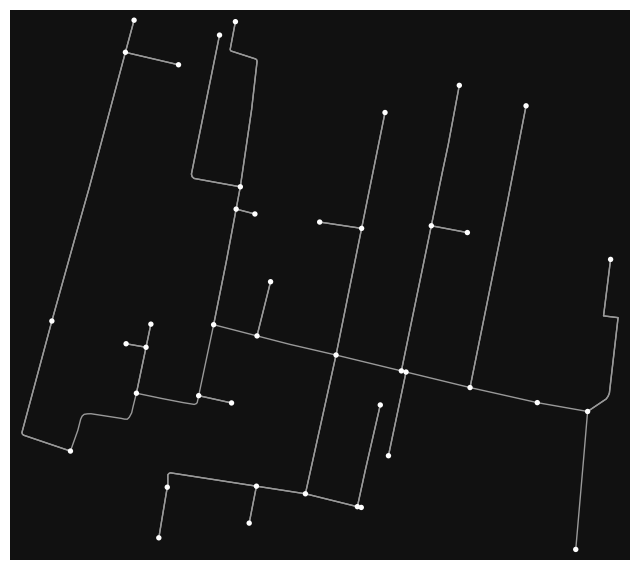

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [250]:
ox.plot_graph(G)

In [298]:
nodes.head()

,y,x,street_count,geometry
osmid,,,,
270672090,13.743376,100.566871,3,POINT (100.56687 13.74338)
270672773,13.740868,100.572794,3,POINT (100.57279 13.74087)
270672774,13.742383,100.572928,3,POINT (100.57293 13.74238)
270672775,13.742480,100.572360,3,POINT (100.57236 13.74248)
270673030,13.742646,100.571599,4,POINT (100.5716 13.74265)


In [299]:
edges.head()

osmid      highway maxspeed  \
u         v           key                                                  
270672090 3483658791  0                   25975737  residential       30   
          280389438   0                   25975737  residential       30   
270672774 11779709621 0    [1268298873, 340273010]  residential      NaN   
          270672773   0                  342245569     tertiary       30   
270672775 270672774   0                  342245569     tertiary       30   

                           oneway       reversed      length  \
u         v           key                                      
270672090 3483658791  0     False          False  340.300840   
          280389438   0     False           True  205.373730   
270672774 11779709621 0     False  [False, True]  215.723913   
          270672773   0      True          False  169.070210   
270672775 270672774   0      True          False   62.370015   

                                                                    geometry  \
u         v           key                                                      
270672090 3483658791  0    LINESTRING (100.56687 13.74338, 100.56713 13.7...   
          280389438   0    LINESTRING (100.56687 13.74338, 100.56653 13.7...   
270672774 11779709621 0    LINESTRING (100.57293 13.74238, 100.57314 13.7...   
          270672773   0    LINESTRING (100.57293 13.74238, 100.57291 13.7...   
270672775 270672774   0    LINESTRING (100.57236 13.74248, 100.57293 13.7...   

                          lanes            name bridge  
u         v           key                               
270672090 3483658791  0     NaN             NaN    NaN  
          280389438   0     NaN             NaN    NaN  
270672774 11779709621 0     NaN             NaN    NaN  
          270672773   0       2  ซอยสุขุมวิท 39    NaN  
270672775 270672774   0       2  ซอยสุขุมวิท 39    NaN

Notes on accessing edges and nodes objects:

In [ ]:
# edges.index   # gives multiindex object of all (u,v,key) edge indices
# edge_endpoints = edges['name'].index.tolist()   # gives (u,v,key) edge indices in a list
# edges.loc[(  270672090,  3483658791, 0)]    # get specific edge info

---

Haversine formula code below copied from: https://gist.github.com/rochacbruno/2883505

In [ ]:
#!/usr/bin/env python

# Haversine formula example in Python
# Author: Wayne Dyck

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d